In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


上面这一行代码用于关联服务器和用户自己的google drive文档，本程序要读取的文件均在google drive上

In [ ]:
'''
This module implements AETG algorithm.
A file of factors and values is needed as input.
The format of the file is in ReadMe.md
Input of the program is the route of the above file and t, since we are generating a t-way combination testing cases.
Output is a csv file in the current working directory, describing all testing cases generated.
Have fun!
By the way, you may want to put this code on a stronger machine since it requires a certain amount of memory and cpu time
'''
import random
import os
import time
import pickle
os.chdir(os.path.join(os.getcwd(),r'gdrive/My Drive/Colab Notebooks/'))
#要更改系统工作目录请修改上一句代码

路径要求：<br>
供测试的因子应该位于./,名为test.txt,编码为utf-8，文件内容形式如下<br><br>
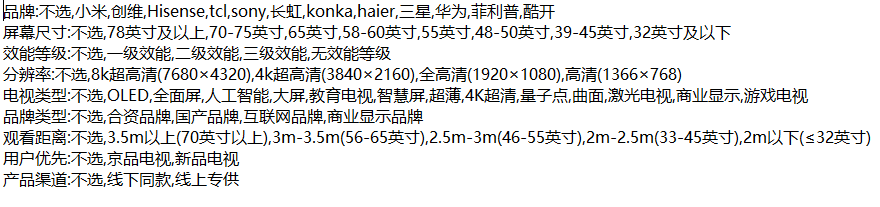
<br>
./路径下有AETG_temp文件夹，用于存储计算的中间结果<br>
生成的testCase输出在./result.csv中，编码为utf-8
要自定义文件以及路径请修改下面代码中的filepath变量的值

In [ ]:
def DFS(t, next_index, factor, current_list, uncoverTuple):
    if len(current_list) == t:
        uncoverTuple.append({'con': current_list.copy(), 'covered': False})
        for ele in current_list:
            factor[ele['index']]['situation'][1][ele['column']] += 1
        return
    if next_index >= len(factor):
        return
    for i in range(next_index, len(factor)):
        # big cycle
        # heading factor from factor[next_index] to factor[last]
        for j, value in enumerate(list(factor[i].values())[1][0]):
            current_list.append({'index': i, 'value': value, 'column': j})
            DFS(t, i + 1, factor, current_list, uncoverTuple)
            current_list.pop()
'''
上面的DFS函数用于生成所有可能的t-way combination
'''

def initial(t, factor, uncoverTuple):
    current_list = []
    DFS(t, 0, factor, current_list, uncoverTuple)


def DFS2(case_value, combin, dim, next_index, current_list):
    if len(current_list) == dim:
        combin.append(current_list.copy())
        return
    for i in range(next_index, len(case_value)):
        current_list.append(case_value[i].copy())
        DFS2(case_value, combin, dim, i + 1, current_list)
        current_list.pop()

'''
DFS2和DFS3，在构建某一个testCase时，我们需要有已经选定的所有value能构成的所有t-way combination，这两个函数用于向数据结构中添加所有的t-way combination
'''
def DFS3(case_value, combin, dim, next_index, current_list, order):
    if len(current_list) == dim:
        combin.append(current_list.copy())
        return
    for i in range(next_index, len(case_value)):
        current_list.append(case_value[i].copy())
        DFS3(case_value, combin, dim, i + 1, current_list, order)
        current_list.pop()


'''
This function tries to list all (t-1)-way combinations out of an array with at least t-1 eles
'''
def listCombination(case_value, dim, order=None):
    combin = []
    current_list = []
    if order is None:
        DFS2(case_value, combin, dim, 0, current_list)
    else:
        DFS3(case_value, combin, dim, 0, current_list, order)
    return combin


def testUncover(case_value, work, t, factor):
    if len(case_value) < t:
        '''
        case_value[]
        ele: 
        [
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        ]
        注意，combin的元素size比work中的元素size小
        work[]
        ele:
        [
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        ]
        '''
        counter = 0
        for each_uncovered in work:
            flag = True
            for each in case_value:
                if not flag:
                    break
                if each not in each_uncovered['con']:
                    flag = False
                    break
            counter = counter + 1 if flag else counter
        return counter

    else:
        counter = 0
        li = case_value.copy()
        last = li.pop()
        combination = listCombination(li, t - 1)

        '''
        是counter少了，不是combination少了？
        是conbination少了。
        '''

        # gives
        for i in range(len(combination)):
            combination[i].append(last)
        '''
        combination[]
        ele: 
        [
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...}
        ]
        
        work[]
        ele:
        [
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        {'value':...,'index':...,'column':...},
        ]
        '''
        for each in combination:
            for each_uncovered in work:
                flag = True
                for each_dic in each:
                    if each_dic not in each_uncovered['con']:
                        flag = False
                        break
                counter = counter + 1 if flag else counter
        return counter


# 在构建每一个testCase时，对于factor_0 - factor_n， 此函数找出对于某一个特定的factor_i的所有可供取值的value中，最好的一个——即取了它之后能够保证覆盖最多的组合
def searchValue(t, factor, uncoverTuple, f_index, case_value, last_cover):
    bestValue = 0
    most_uncover = 0
    for i, value in enumerate(factor[f_index]['situation'][0]):
        # test each attribute in this factor
        case_value.append({'value': value, 'index': f_index, 'column': i})
        work = uncoverTuple.copy()
        this_uncover = testUncover(case_value, work, t, factor)
        if this_uncover > most_uncover or (this_uncover == 0 and most_uncover == 0):
            # when both are 0 we still record a value
            most_uncover = this_uncover
            bestValue = value
        case_value.pop()
    if len(case_value) >= t:
        most_uncover += last_cover
    return bestValue, most_uncover


# 此函数用于生成M个case，并返回最好的一个testCase以及它所覆盖的组合个数
# 在添加一个testCase（n个value的元组）的过程中，被添加上去的testCase是从M个testCase中选的最好的一个。
def generateMcase(M, t, factor, uncoverTuple):
    Permuted = []
    BestCase = None
    case_value = []
    cover_new = 0
    # order = None
    '''
    Step 1: select f_1
    Do this once is enough
    '''
    max_cover = 0
    factor_index = 0
    value_index = 0

    find_array = [i for i in range(len(factor))]
    random.shuffle(find_array)
    # 随机将factor的数组排序，保证当有多个factor候选时，不会因为某一个factor排在前面而且不能提供有效的更新时，导致程序卡死
    for i in range(len(find_array)):
        ele = factor[i]
        # iterate the whole factor dictionary
        # find the value v_i for factor_i which makes most uncovered t-way combinations.
        if max(ele['situation'][1]) > max_cover:
            max_cover = max(ele['situation'][1])
            factor_index = i
            value_index = ele['situation'][1].index(max_cover)
    Permuted.append(factor_index)
    case_value.append(
        {'value': factor[factor_index]['situation'][0][value_index], 'index': factor_index, 'column': value_index})
    origin = case_value.copy()
    for i in range(M):
        if (i + 1) % 10 == 0 or i == 0:
            print(f'I = {i + 1} \t', end='')
        '''
        Step 2
        Permute f_2 ~ f_k
        '''
        temp = [j for j in range(len(factor))]
        temp.remove(factor_index)
        random.shuffle(temp)
        Permuted.extend(temp)
        case_value = origin.copy()
        last_cover = None
        '''
        Step 3
        pick values for f_2 ~ f_k
        '''
        for index in range(1, len(factor)):
            picked_value, cover_new = searchValue(t, factor, uncoverTuple, Permuted[index], case_value, last_cover)
            # if value returned is 0,0
            # then we know this permutation is
            last_cover = cover_new
            case_value.append({'value': picked_value, 'index': Permuted[index],
                               'column': factor[Permuted[index]]['situation'][0].index(picked_value)})
            # pick a value from f_2 to f_k
        if BestCase is not None and BestCase['cover_new'] > cover_new:
            continue
        else:
            if BestCase is None:
                BestCase = {'case': case_value.copy(), 'cover_new': cover_new}
                # order = Permuted.copy()
            if BestCase['cover_new'] < cover_new:
                BestCase['case'] = case_value.copy()
                BestCase['cover_new'] = cover_new
                # order = Permuted.copy()
    print()
    return case_value, cover_new

# 选出一个testCase后，要更新未被覆盖的组合的集合
def updateUncover(uncoverTuple, candidate, dim, factor):
    all_combins = listCombination(candidate, dim, True)
    '''    
    uncoverTuple is a set
    each ele is a dictionary
    {'con':[],'covered':false}
    ele in 'con'
    [
      {'index':...,'value':...,'column':...},
      {'index':...,'value':...,'column':...},
      {'index':...,'value':...,'column':...}
    ]
    
    all_combins:  []
    ele in all_combins:
    [
        {'index':...,'value':...,'column':...},
        {'index':...,'value':...,'column':...},
        {'index':...,'value':...,'column':...}
    ]
    '''
    counter = 0
    for each in uncoverTuple:
        # {'con':...,'covered':...}
        if each['covered']:
            continue
        for each_ele in all_combins:
            # [  {'index':...,'value':...,'column':...},{},{}]
            flag = True
            if not flag:
                break
            for each_dic in each_ele:
                # {}
                flag = False if each_dic not in each['con'] else flag
                if not flag:
                    break
            if flag:
                counter += 1
                uncoverTuple.remove(each)
                for each_dic in each_ele:
                    factor[each_dic['index']]['situation'][1][each_dic['column']] -= 1

    return counter

# 此函数用于输出程序生成的结果到csv中
def out(testcase, factor):
    factor_list = [i['name'] for i in factor]
    with open(r'./result.csv', encoding='utf8', mode='w') as f:
        for i, data in enumerate(factor_list):
            f.write(str(data) + ',')
        f.write('覆盖组合个数\n')
        for each_case in testcase:
            temp_list = [i for i in range(len(factor))]
            for each_dictionary in each_case['case']:
                temp_list[each_dictionary['index']] = str(each_dictionary['value']) + ','
            temp_list.append(str(each_case['cover']) + '\n')
            for each in temp_list:
                f.write(each)

# 以下两个函数用于将计算的中间结果序列化和反序列化
# 白嫖版google colab一次性使用时间最长是12h，而完成一次计算需要43h，因此要在笔记本资源被回收之间将中间结果写到文件中。
def store(time_cost,  uncoverTuple, testCase, factor):
    with open(r'./AETG_temp/time.bin', 'wb') as f:
        pickle.dump(time_cost, f, 1)
    # with open(r'./newCover.bin', 'wb')as f:
    #     pickle.dump(newCover, f, 1)
    with open(r'./AETG_temp/uncoverTuple.bin', 'wb') as f:
        pickle.dump(uncoverTuple, f, 1)
    with open(r'./AETG_temp/testCase.bin', 'wb') as f:
        pickle.dump(testCase, f, 1)
    with open(f'./AETG_temp/factor.bin', 'wb') as f:
        pickle.dump(factor, f, 1)


def restore():
    time_cost, uncoverTuple, testCase, factor = None, None, None, None
    with open(r'./AETG_temp/time.bin', 'rb') as f:
        time_cost = pickle.load(f)
    # with open(r'./newCover.bin', 'rb')as f:
    #     newCover = pickle.load(f)
    with open(r'./AETG_temp/uncoverTuple.bin', 'rb') as f:
        uncoverTuple = pickle.load(f)
    with open(r'./AETG_temp/testCase.bin', 'rb') as f:
        testCase = pickle.load(f)
    with open(f'./AETG_temp/factor.bin', 'rb') as f:
        factor = pickle.load(f)
    return time_cost,uncoverTuple,testCase,factor



In [ ]:
#这段代码一定要跑，用于初始化必需的参数
uncoverTuple = []
testCase = []
factor = []
M = 50
last=0
t = 3
# 修改参数 t 可以以t-way combination生成testCase，理论上支持所有大于1的自然数
filePath = r'./problem2_factor.txt'
# 这个路径是装着factor的文件的路径，可以自行修改
batch_time=float(input('Give running hours:'))
# 输入此次计算的预定时间，笔记本将会在时间到达后将中间结果写到文件中去，并且自动停止。

Give running hours:4


* Choose to initial or reload


In [ ]:
# 因为是白嫖的colab，每计算12小时笔记本的资源会被回收。
# 每12小时要保存一次中间结果，然后重新连接，读回中间结果，继续计算
# 将数据结构序列化到文件中，重新上线后再反序列化 ok
# 计算的代码相同，只要保证重装数据的改变对计算代码透明
'''
while 第一句之前，先判断是不是应该停了。
如果跑到了十一个半小时，那么
将uncoverTuple,testCase,newCover,factor,M,t,total(total-time.time()+last)
全部序列化出去

恢复：
last=total.deser
M,t,newCover = deser
uncoverTuple,testCase = derser
重做函数定义
重新import
重新定位到文件夹
total=time.time()
重新开始计算

seralize(...)
deseralize(...)
'''

In [ ]:
# initial code: only run once.
# 只有第一次运行时才会跑这一段代码，如果是要接着上一次计算结果，请跑下一段代码。
with open(filePath, encoding='utf8') as f:
    temp = [i.strip(' \t\n').split(',') for i in f]
    for i, each in enumerate(temp):
        temp[i][0:1] = each[0].split(':')
    for i, each in enumerate(temp):
        factor.append({'name': temp[i][0], 'situation': [temp[i][1:], [0 for i in range(len(temp[i]) - 1)]]})
initial(t, factor, uncoverTuple)
print(f'Finish initialization, size of uncoverTuple: {len(uncoverTuple)}')


Finish initialization, size of uncoverTuple: 31949


In [ ]:
# 将文件中的数据结构重新load回来，恢复状态。
last, uncoverTuple, testCase, factor = restore()
print(f'trained_hours_accumulated = {last/3600}')
print("uncoverTuple.size() = ",len(uncoverTuple))
print("testCase.size() = ",len(testCase))
print(f"Next calculation period : {batch_time}hour(s)")

trained_hours_accumulated = 42.72647020816803
uncoverTuple.size() =  228
testCase.size() =  2577
Next calculation period : 4.0hour(s)


In [ ]:
# 计算用代码
total=time.time()
while (len(uncoverTuple)):
    if  (time.time()-total)/3600>batch_time:
        store(last+time.time()-total,uncoverTuple,testCase,factor)
        break
    # tempp=time.time()-total
    # store(tempp,uncoverTuple,testCase,factor)
    # temp1,temp3,temp4,temp5 = restore()
    # print(f'After restore: timeCost:{tempp==temp1}\nuncoverTuple:{ uncoverTuple == temp3}\ntestCase:{testCase == temp4}\nfactor:{factor == temp5}')
    print('Searching for M cases :\t', end='')
    timer = time.time()
    candidate, newCover = generateMcase(M, t, factor, uncoverTuple)
    '''for each in uncoverTuple:
          if  each['covered']:
              print(each['con'])'''
    print('Searching finished, time costs = %2.5fs\t' % (time.time() - timer), end='')
    if newCover:
        updateUncover(uncoverTuple, candidate, t, factor)
        testCase.append({'case': candidate, 'cover': newCover})
        print(f'Size of testCase:{len(testCase)}, uncoveredTuple: {len(uncoverTuple)}')
    else:
        print('This search gives no update.')

out(testCase, factor)
if len(uncoverTuple) == 0:
  print('Algorithm finished, total time costs = %2.3fh' % ((time.time() - total+last) / 3600)) 
else :
  print('Task temporarily done, time costs = %2.3fh' % ((time.time() - total+last) / 3600))
print('Finish writing results to ./result.rsv')

Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 1.25850s	Size of testCase:2578, uncoveredTuple: 227
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 1.49945s	This search gives no update.
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 1.07456s	Size of testCase:2579, uncoveredTuple: 225
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 1.27375s	Size of testCase:2580, uncoveredTuple: 223
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 1.54824s	This search gives no update.
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching finished, time costs = 2.16494s	Size of testCase:2581, uncoveredTuple: 222
Searching for M cases :	I = 1 	I = 10 	I = 20 	I = 30 	I = 40 	I = 50 	
Searching fini

In [ ]:
'''
When you want to stop calculating before the ddl you set, stop the code block above and run this line immediately.
'''
store(last+time.time()-total,uncoverTuple,testCase,factor)